In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_excel("knn\Presidentielle_2017_Resultats_Communes_Tour_2_c.xls",header=3)
print(df.head(2))
print("----------------------------------------------")
print(df.info())

  Code du département Libellé du département  Code de la commune  \
0                   1                    Ain                   1   
1                   1                    Ain                   2   

     Libellé de la commune  Inscrits  Abstentions  % Abs/Ins  Votants  \
0  L'Abergement-Clémenciat       598          100      16.72      498   
1    L'Abergement-de-Varey       209           32      15.31      177   

   % Vot/Ins  Blancs  % Blancs/Ins  % Blancs/Vot  Nuls  % Nuls/Ins  \
0      83.28      37          6.19          7.43     8        1.34   
1      84.69      21         10.05         11.86     6        2.87   

   % Nuls/Vot  Exprimés  % Exp/Ins  % Exp/Vot  N°Panneau Sexe     Nom  \
0        1.61       453      75.75      90.96          1    M  MACRON   
1        3.39       150      71.77      84.75          1    M  MACRON   

     Prénom  Voix  % Voix/Ins  % Voix/Exp  N°Panneau.1 Sexe.1   Nom.1  \
0  Emmanuel   272       45.48       60.04            2      F  LE PEN  

In [4]:
print('Dataframe dimensions:', df.shape)
#____________________________________________________________
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
print(tab_info.head(5))

Dataframe dimensions: (35719, 32)
                 Code du département Libellé du département  \
column type                   object                 object   
null values (nb)                   0                      0   
null values (%)                    0                      0   

                 Code de la commune Libellé de la commune Inscrits  \
column type                   int64                object    int64   
null values (nb)                  0                     0        0   
null values (%)                   0                     0        0   

                 Abstentions % Abs/Ins Votants % Vot/Ins Blancs % Blancs/Ins  \
column type            int64   float64   int64   float64  int64      float64   
null values (nb)           0         0       0         0      0            0   
null values (%)            0         0       0         0      0            0   

                 % Blancs/Vot   Nuls % Nuls/Ins % Nuls/Vot Exprimés % Exp/Ins  \
column type           float64 

In [5]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,Code du département,0,100.0
1,Voix.1,0,100.0
2,Prénom.1,0,100.0
3,Nom.1,0,100.0
4,Sexe.1,0,100.0
5,N°Panneau.1,0,100.0
6,% Voix/Exp,0,100.0
7,% Voix/Ins,0,100.0
8,Voix,0,100.0
9,Prénom,0,100.0


In [6]:
# select important French department
df = df[df["Code du département"].isin([75,91,92,93,94,95,77,78])]
abbr_regions = {"Paris":75,"Essonne":91,"Hauts-de-Seine":92,"Seine-Saint-Denis":93,"Val-de-Marne":94,"Val-d'Oise":95,\
                  "Seine-et-Marne":77,"Yvelines":78}
# df["Code du département"].value_counts()=="75"


In [7]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['% Abs/Ins'].groupby(df['Libellé du département']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
Libellé du département,,,,
Paris,1.0,21.51,21.510000,21.51
Hauts-de-Seine,36.0,35.55,22.908611,16.62
Seine-Saint-Denis,40.0,42.32,32.035000,22.04
Val-de-Marne,47.0,32.75,26.064255,19.22
Val-d'Oise,185.0,36.68,22.680108,6.25
Essonne,196.0,39.13,21.968980,8.06
Yvelines,262.0,35.45,20.190954,11.23
Seine-et-Marne,510.0,37.92,22.239333,8.24


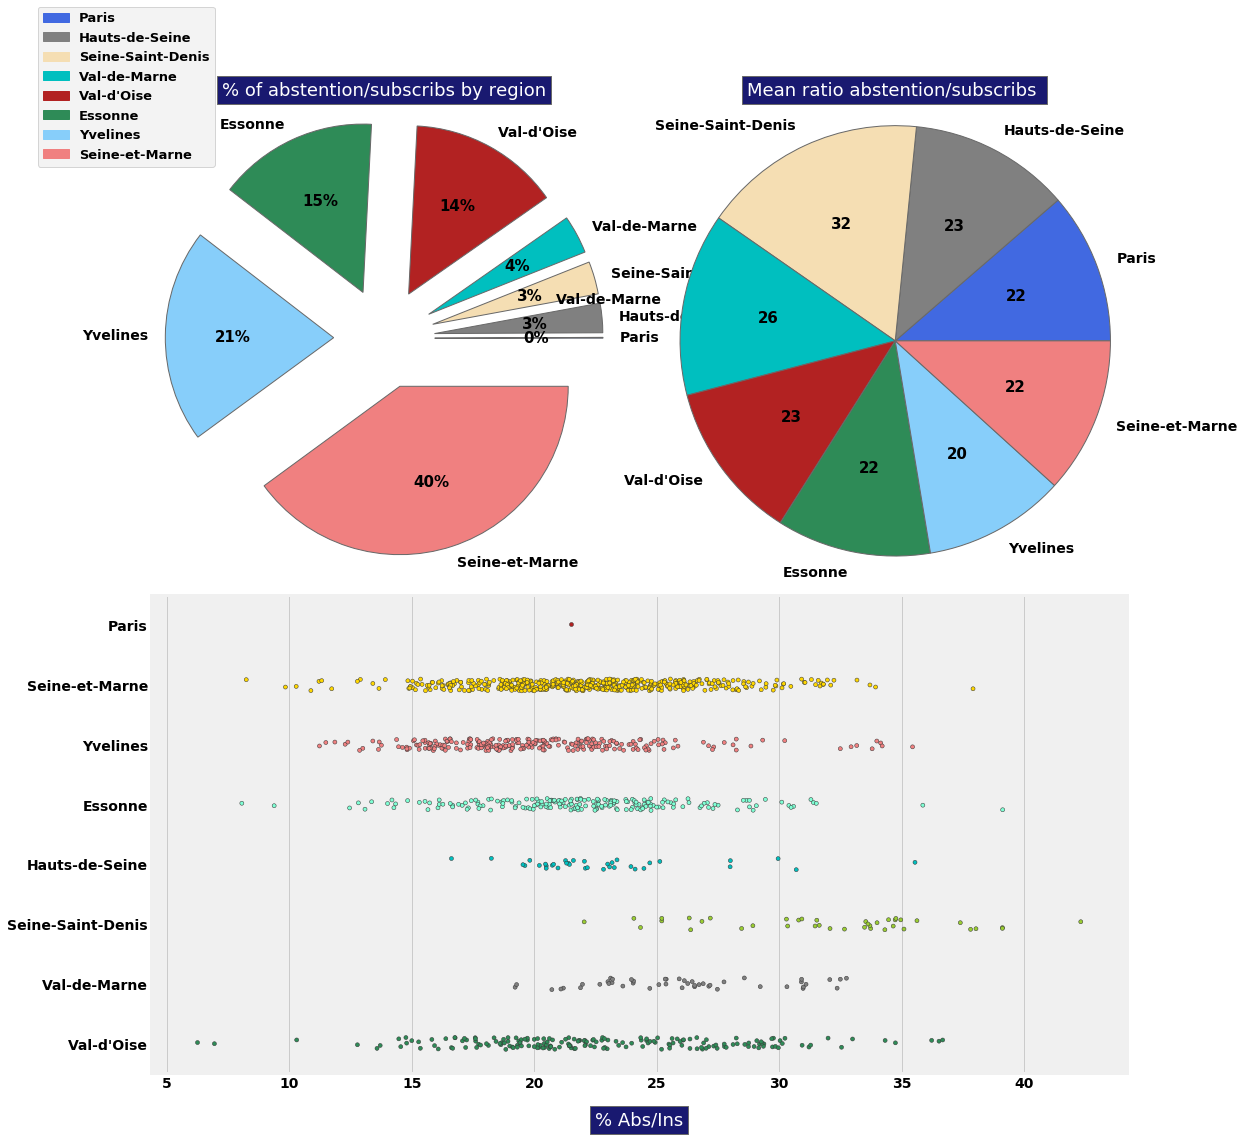

In [8]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)
import matplotlib.patches as mpatches
#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['Libellé du département', '% Abs/Ins']]
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse',
          '#FFFF00', '#00AAFF', '#000000', '#FF00AA','R','B','G','K',
        '#F5F5DC','#BEBEBE','#F0E68C','#D2691E','#331E28','#FF99CC','#99FFCC',
            '#CCFFE6','#FFCCFF','#CCCCFF','#FFFFCC','#979785','#488997','#EDEEE3',
            '#5CB0C2','#5199A8','#07A3B2','#BA3951','#4B0D2B','#E9B704','#8E3843',
            '#134913','#C50D63','#CD7EA0','#596B53','#9A616E','#82486B','#95818C',
            '#07A3B2','#C50D63','#E47446','#055F65','#CBAA5C','#076E4E']

#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of 
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(global_stats))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(global_stats)): 
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of abstention/subscribs by region', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#_______________________________________________
# I set the legend: 
comp_handler = []
for i in range(len(global_stats)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label =  global_stats.index[i]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(global_stats))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(global_stats)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean ratio abstention/subscribs ', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the 
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="Libellé du département", x="% Abs/Ins", size = 4, palette = colors,
                    data=df2.iloc[:10000,:] , linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
# ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
#                          for x in ax3.get_xticks()])
plt.xlabel('% Abs/Ins', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3) 

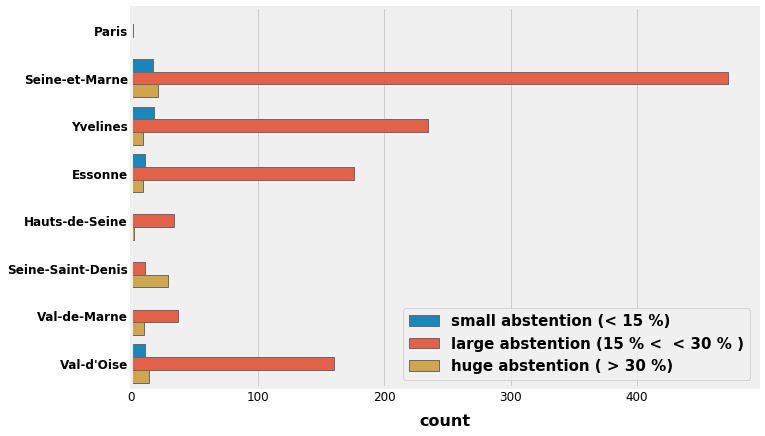

In [9]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 15],2)[x > 30]
df['WHITE_BALLOT_LEVEL'] = df['% Abs/Ins'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="Libellé du département", hue='WHITE_BALLOT_LEVEL', data=df )
#____________________________________________________________________________________
# Set the labels
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('small abstention (< 15 %)')
L.get_texts()[1].set_text('large abstention (15 % <  < 30 % )')
L.get_texts()[2].set_text('huge abstention ( > 30 %)')
plt.show()

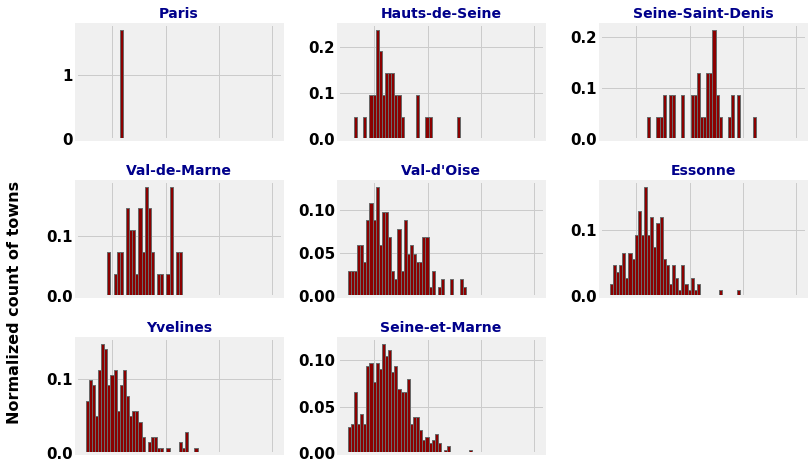

In [11]:
import numpy as np

points = [] ; labels = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for depart_name in list(global_stats.index):
    i += 1
    ax = fig.add_subplot(5,3,i)    
    n, bins, patches = plt.hist(x =  df[df['Libellé du département']==depart_name]['% Abs/Ins']\
                                ,range = (15,50), normed=True, bins= 60, color='darkred')
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    #___________________________
    # bookeeping of the results
    labels.append(depart_name)
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels([ax.get_xticks()])
    #______________
    # subplot title
    plt.title(depart_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of towns', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Ratio of abstention', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    
plt.tight_layout()

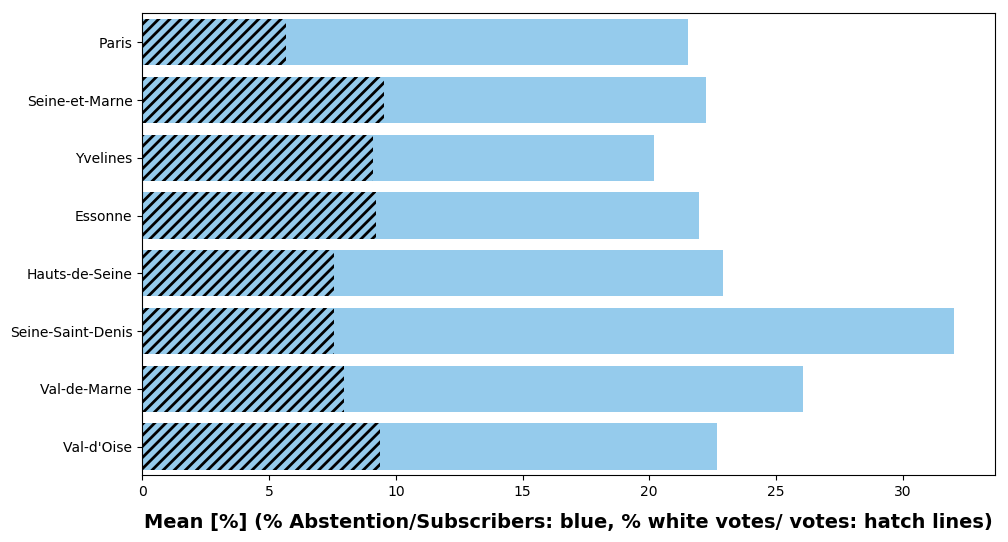

In [12]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="% Abs/Ins", y="Libellé du département", data=df, color="lightskyblue", ci=None)
ax = sns.barplot(x="% Blancs/Vot", y="Libellé du département", data=df, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean [%] (% Abstention/subscribs: blue, % white votes/ votes: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

In [29]:
town_details = pd.DataFrame(pd.Series(df['Libellé de la commune'].unique()))
town_details.set_index(0, drop = True, inplace = True)

for depart_name in list(global_stats.index):
    df1 = df[df['Libellé du département'] == depart_name]
    test = df1['% Abs/Ins'].groupby(df['Libellé de la commune']).apply(get_stats).unstack()
    town_details[depart_name] = test.loc[:, 'mean'] 

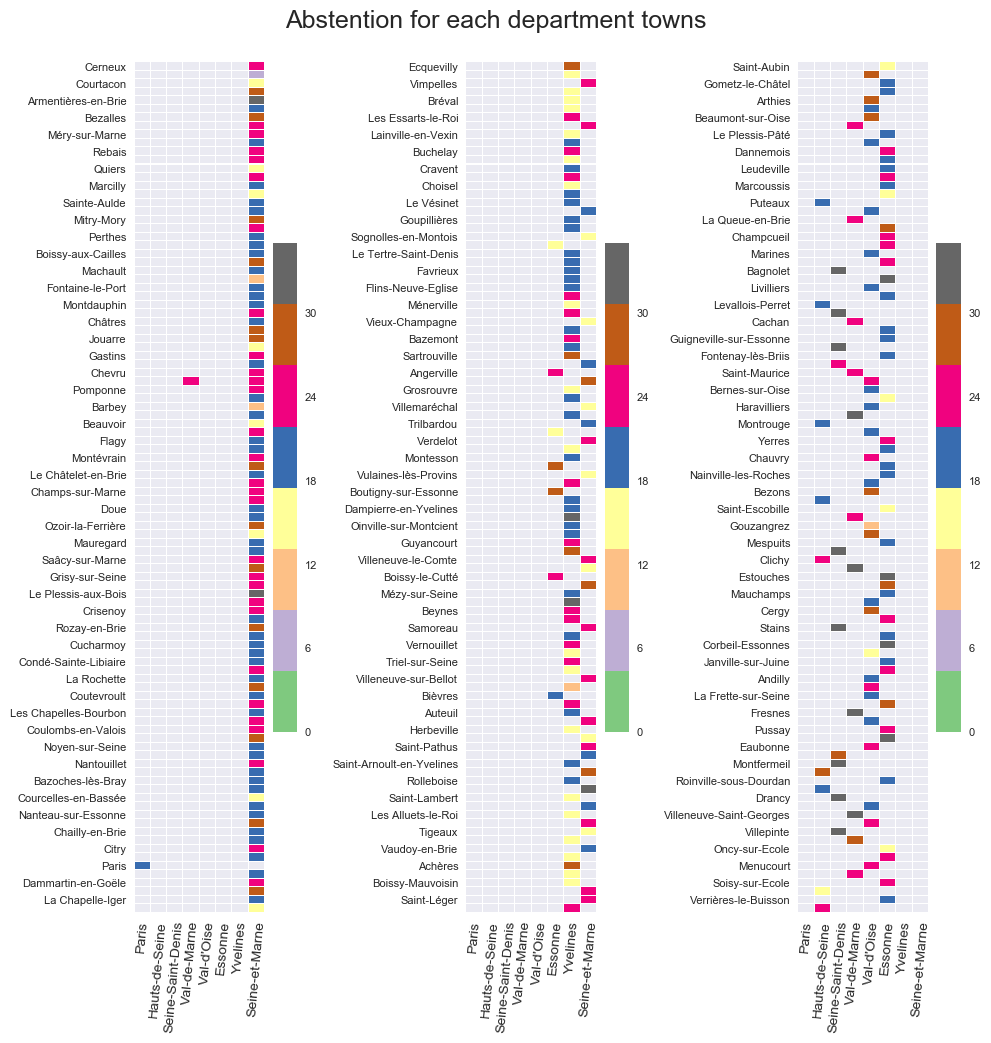

In [39]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(10,10))
perm1 = np.random.permutation(np.arange(0,400,4))
perm2 = np.random.permutation(np.arange(400,800,4))
perm3 = np.random.permutation(np.arange(800,1200,4))
ax = fig.add_subplot(1,3,1)
subset = town_details.iloc[perm1,:]
subset = subset
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,3,2)    
subset = town_details.iloc[perm2,:]
subset = subset
fig.text(0.5, 1.02, "Abstention for each department towns", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,3,3)
subset = town_details.iloc[perm3,:]
subset = subset
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()